In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

Filtering 2012-2024 Data Sicilia

In [3]:

# Carica i file GeoJSON della Sicilia
sicilia_fires = gpd.read_file('Sicilia/fires.geojson')
sicilia_fires_complete = gpd.read_file('Sicilia/fires_complete.geojson')

# Converti la colonna con le date in formato datetime
date_column = 'DATI_WEB.DBO.DFCNSIINCD_DENORM.DTAINIZIOFUOCO'

for df in [sicilia_fires, sicilia_fires_complete]:
    df[date_column] = pd.to_datetime(
        df[date_column],
        format='%B %d, %Y',  # Formato personalizzato per es. "August 5, 2013"
        errors='coerce'
    )

# Definisci l'intervallo di date
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2024-12-31')

# Filtra i dati
fires_filtered = sicilia_fires[
    (sicilia_fires[date_column] >= start_date) & 
    (sicilia_fires[date_column] <= end_date)
]

fires_complete_filtered = sicilia_fires_complete[
    (sicilia_fires_complete[date_column] >= start_date) & 
    (sicilia_fires_complete[date_column] <= end_date)
]

# Salva i risultati
fires_filtered.to_file("Sicilia_2012_2024/fires_filtered.geojson", driver='GeoJSON')
fires_complete_filtered.to_file("Sicilia_2012_2024/fires_complete_filtered.geojson", driver='GeoJSON')

print(f"Numero di incendi in fires: {len(fires_filtered)}")
print(f"Numero di incendi in fires_complete: {len(fires_complete_filtered)}")

Numero di incendi in fires: 1000
Numero di incendi in fires_complete: 12014


Cutting of Sicily from EFFIS Json (run only one time)

In [5]:
effis = gpd.read_file("../EFFIS_IT_EL_FR_PT_2021_2024\EFFIS_IT_EL_FR_PT_2021_2024.json")

#Filtering for corsica data
effis_sicilia = effis[
    (effis["country"] == "Italia") & 
    (
        (effis["admlvl1"].str.contains("Sicilia", case=False)) |
        (effis["admlvl2"].str.contains("Sicilia", case=False))
    )
]
effis_sicilia=effis_sicilia.to_crs(epsg=4326)
print(len(effis_sicilia))

effis_sicilia.to_file("Sicilia_2012_2024/effis_sicilia.geojson", driver="GeoJSON")

3496


Comparison different data

EPSG:3857
EPSG:3857
EPSG:3857


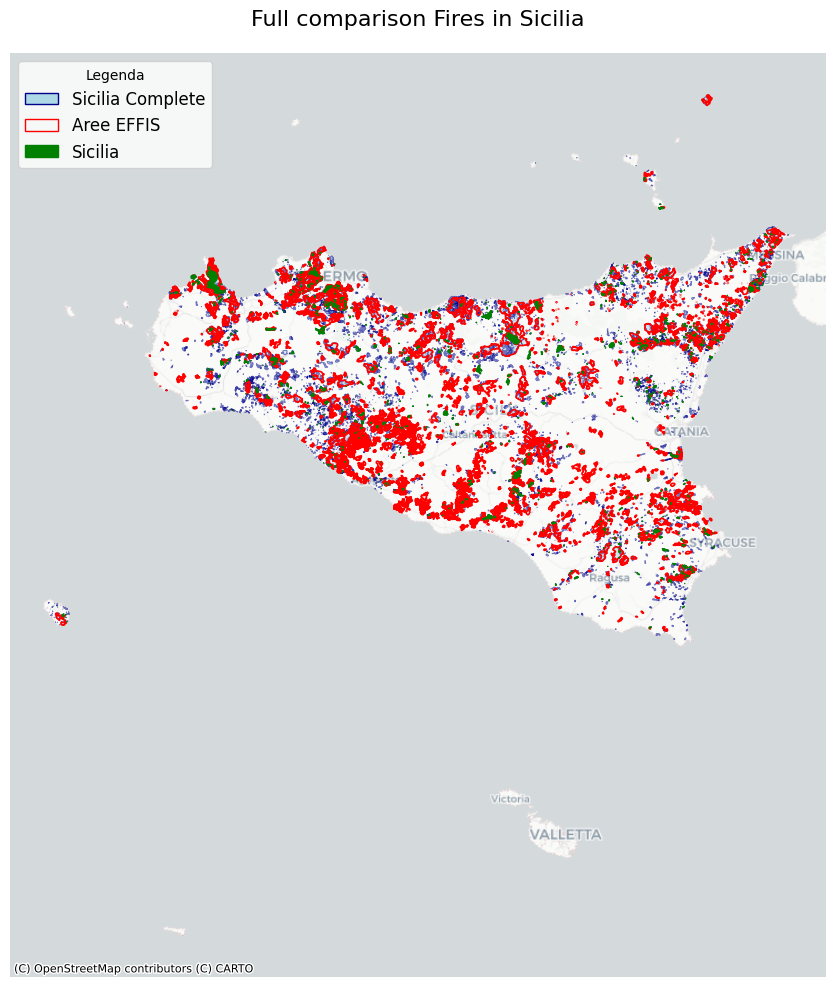

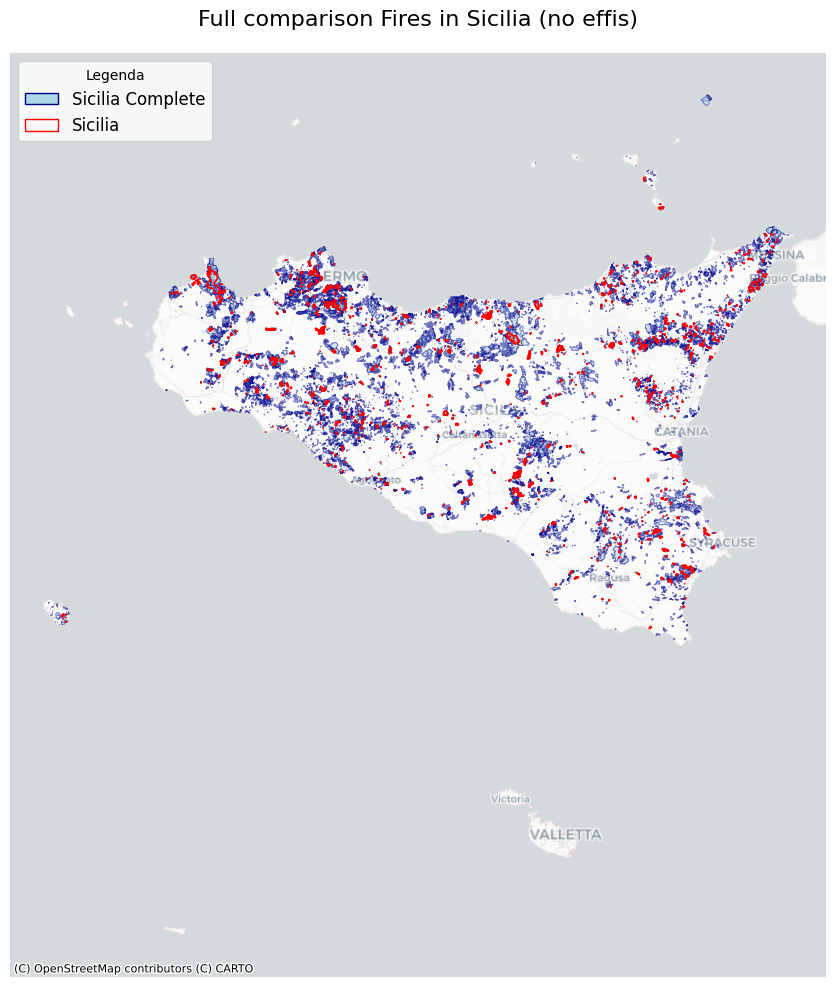

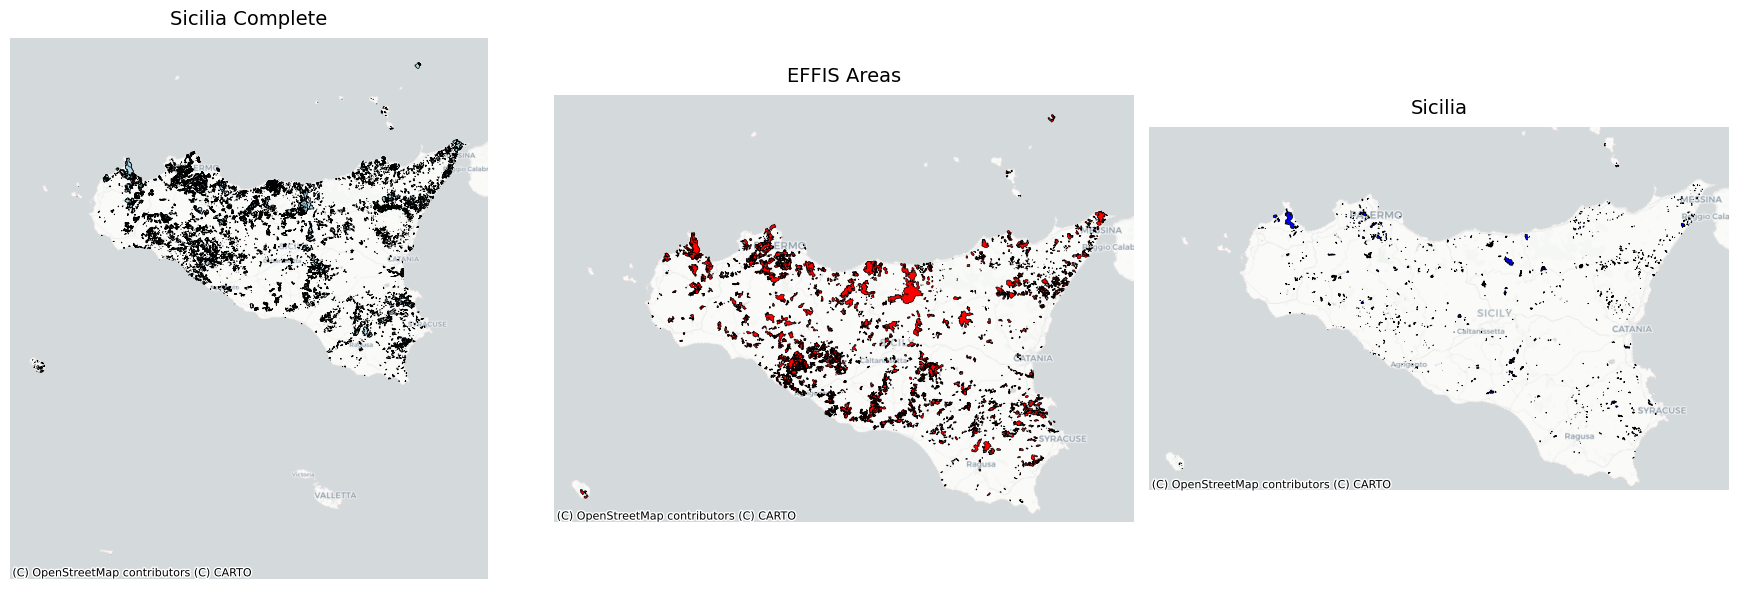

In [11]:

#####Composed Map
effis_sicilia=gpd.read_file("Sicilia_2012_2024/effis_sicilia.geojson")
sicilia_fires_complete=gpd.read_file("Sicilia_2012_2024/fires_complete_filtered.geojson")
sicilia_fires=gpd.read_file("Sicilia_2012_2024/fires_filtered.geojson")

# Convert to Web Mercator for plotting
effis_sicilia = effis_sicilia.to_crs(epsg=3857)
sicilia_fires_complete = sicilia_fires_complete.to_crs(epsg=3857)
sicilia_fires = sicilia_fires.to_crs(epsg=3857)


print(sicilia_fires.crs)
print(sicilia_fires_complete.crs)
print(effis_sicilia.crs)


fig = plt.figure(figsize=(22, 22))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])


ax_main = fig.add_subplot(gs[0])

#1. Complete fires Sicilia
sicilia_fires_complete.plot(
    ax=ax_main,
    facecolor="lightblue",
    edgecolor="darkblue",
    alpha=0.5,
    linewidth=0.7
)

#2. EFFIS fire areas
effis_sicilia.plot(
    ax=ax_main,
    facecolor="none",
    edgecolor="red",
    linewidth=1.2
)

#3. Sicilia fires
sicilia_fires.plot(
   ax=ax_main,
    facecolor="green",
    edgecolor="green",
    linewidth=0.8
)

# Base map and title
ctx.add_basemap(ax_main, source=ctx.providers.CartoDB.Positron, zoom=8)
ax_main.set_title("Full comparison Fires in Sicilia", fontsize=16, pad=20)
ax_main.axis("off")

#MANUAL LEGEND
legend_elements = [
    mpatches.Patch(facecolor="lightblue", edgecolor="darkblue", label="Sicilia Complete"),
    mpatches.Patch(facecolor="none", edgecolor="red", label="Aree EFFIS"),
    mpatches.Patch(facecolor="green", edgecolor="green", label="Sicilia")
]

ax_main.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=12, title="Legenda")

#####Composed Map only Sicilia
fig1 = plt.figure(figsize=(22, 22))
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])


ax_main1 = fig1.add_subplot(gs[0])

#1. Sicilia Complete
sicilia_fires_complete.plot(
    ax=ax_main1,
    facecolor="lightblue",
    edgecolor="darkblue",
    alpha=0.5,
    linewidth=0.7
)

#2. Sicilia
sicilia_fires.plot(
    ax=ax_main1,
    facecolor="none",
    edgecolor="red",
    linewidth=1.2
)


# Base map and title
ctx.add_basemap(ax_main1, source=ctx.providers.CartoDB.Positron, zoom=8)
ax_main1.set_title("Full comparison Fires in Sicilia (no effis)", fontsize=16, pad=20)
ax_main1.axis("off")

#MANUAL LEGEND
legend_elements = [
    mpatches.Patch(facecolor="lightblue", edgecolor="darkblue", label="Sicilia Complete"),
    mpatches.Patch(facecolor="none", edgecolor="red", label="Sicilia")]

ax_main1.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=12, title="Legenda")

#################3 SEPARATE GRAPHS (NEXT TO EACH OTHER)
fig2, ax_sub = plt.subplots(1, 3, figsize=(18, 6) )

datasets = [
    (sicilia_fires_complete, "Sicilia Complete", "lightblue"),
    (effis_sicilia, "EFFIS Areas", "red"),
    (sicilia_fires, "Sicilia", "blue")
    
]

# Plot per ogni dataset
for ax, (data, title, color) in zip(ax_sub, datasets):
    if "Punti" in title:
        data.plot(ax=ax, markersize=10, marker="x", color=color)
    else:
        data.plot(ax=ax, facecolor=color, edgecolor="black", linewidth=0.5)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=8)
    ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

Geographic Distribution, Burned Area Dimension   ---> EFFIS VS COMPLETE

EFFIS area: 290742.4 ha
Sicilia Complete area: 265095.7 ha
Overlapping area: 170966.4 ha
EFFIS only area: 119775.9 ha
Sicilia Complete only area: 94129.3 ha


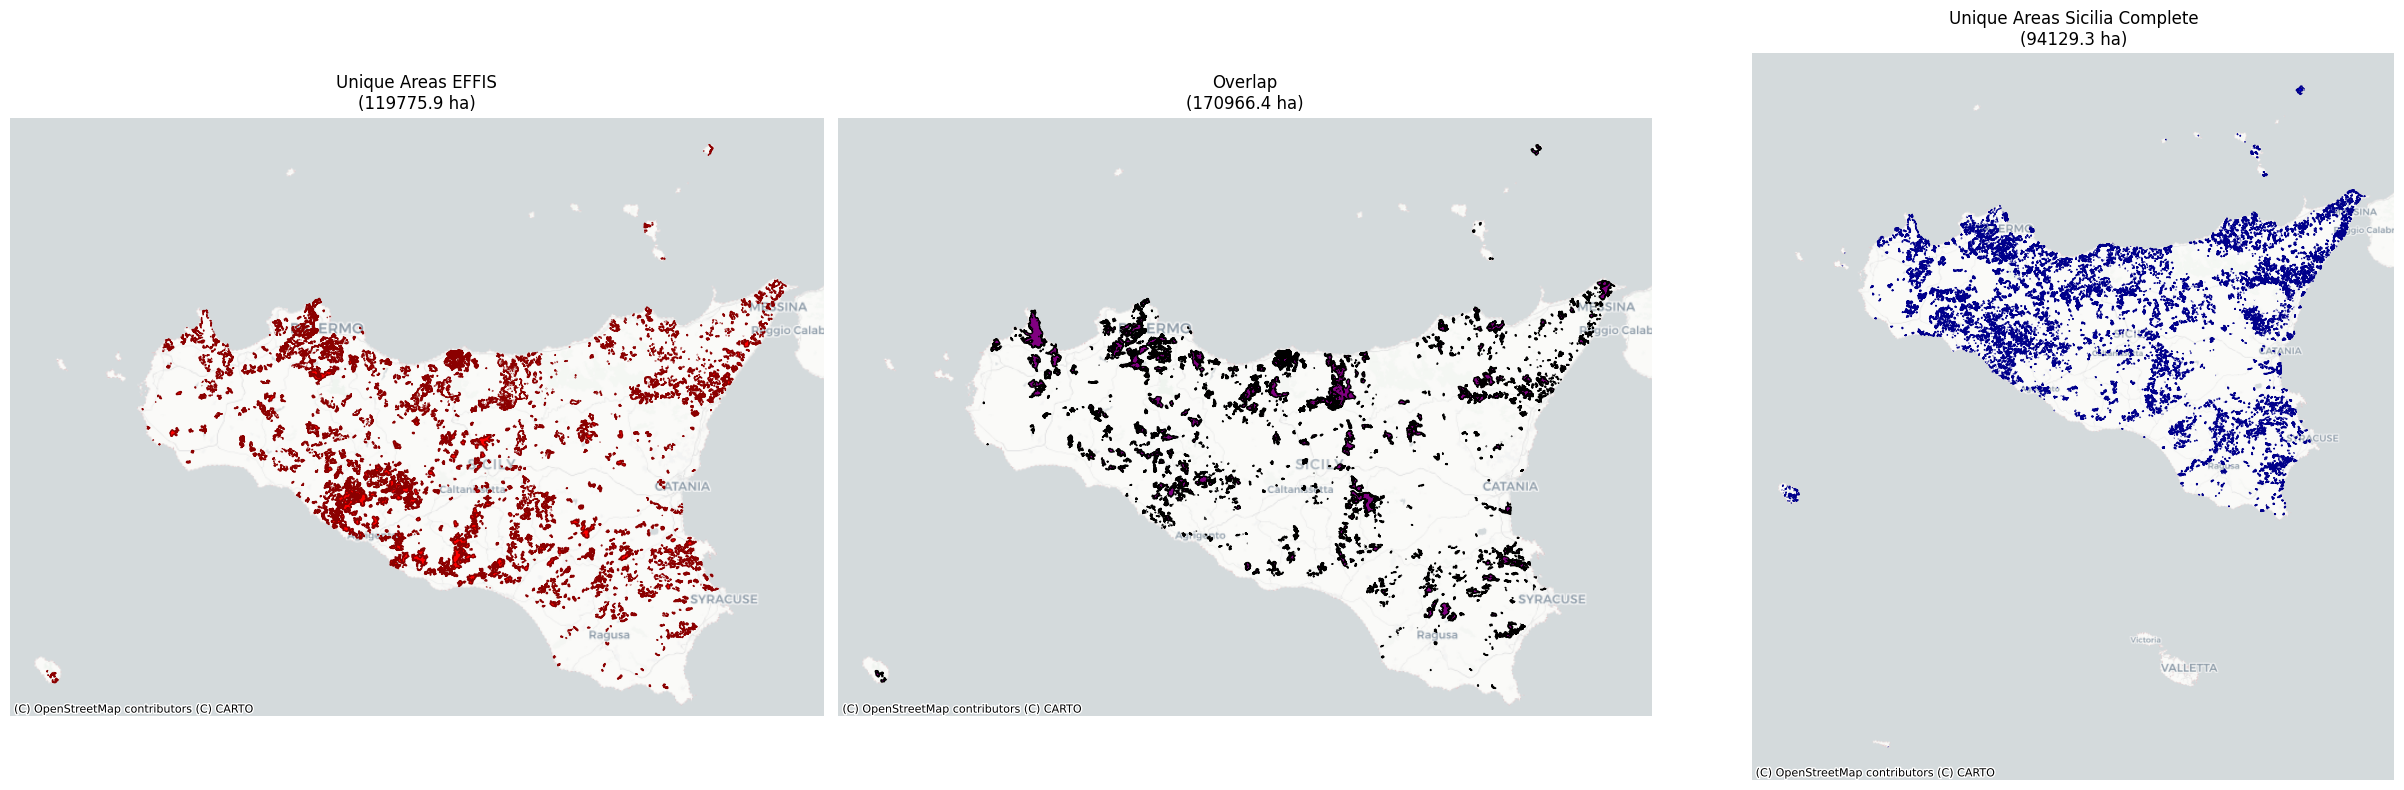

In [17]:
from shapely.ops import unary_union

# Load and reproject data
effis_sicilia = gpd.read_file("Sicilia_2012_2024/effis_sicilia.geojson").to_crs(epsg=32633)
sicilia_fires_complete = gpd.read_file("Sicilia_2012_2024/fires_complete_filtered.geojson").to_crs(epsg=32633)

# Fix geometries
effis_sicilia["geometry"] = effis_sicilia["geometry"].buffer(0)
sicilia_fires_complete["geometry"] = sicilia_fires_complete["geometry"].buffer(0)

# Unary Union computation
effis_union = unary_union(effis_sicilia.geometry)
cp_union = unary_union(sicilia_fires_complete.geometry)

# Areas computation in hectares
area_effis = effis_union.area / 10_000
area_cp = cp_union.area / 10_000

# Overlapping and unique areas
overlap_geometry = effis_union.intersection(cp_union)
effis_unique_geometry = effis_union.difference(cp_union)
cp_unique_geometry = cp_union.difference(effis_union)

overlap_area = overlap_geometry.area / 10_000
effis_unique = effis_unique_geometry.area / 10_000
cp_unique = cp_unique_geometry.area / 10_000

# Print results
print(f"EFFIS area: {area_effis:.1f} ha")
print(f"Sicilia Complete area: {area_cp:.1f} ha")
print(f"Overlapping area: {overlap_area:.1f} ha")
print(f"EFFIS only area: {effis_unique:.1f} ha")
print(f"Sicilia Complete only area: {cp_unique:.1f} ha")

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(25, 8))

# Unique EFFIS
gpd.GeoDataFrame(geometry=[effis_unique_geometry], crs="EPSG:32633").to_crs(epsg=3857).plot(
    ax=axs[0], color="red", edgecolor="darkred")
axs[0].set_title(f"Unique Areas EFFIS\n({effis_unique:.1f} ha)")

# Overlap
gpd.GeoDataFrame(geometry=[overlap_geometry], crs="EPSG:32633").to_crs(epsg=3857).plot(
    ax=axs[1], color="purple", edgecolor="black")
axs[1].set_title(f"Overlap\n({overlap_area:.1f} ha)")

# Unique Sicilia Complete
gpd.GeoDataFrame(geometry=[cp_unique_geometry], crs="EPSG:32633").to_crs(epsg=3857).plot(
    ax=axs[2], color="blue", edgecolor="darkblue")
axs[2].set_title(f"Unique Areas Sicilia Complete\n({cp_unique:.1f} ha)")

# Basemap
for ax in axs:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


Temporal Distribution and Seasonal Distribution

N. incendi EFFIS: 3496
N. incendi Sicilia Complete: 12014


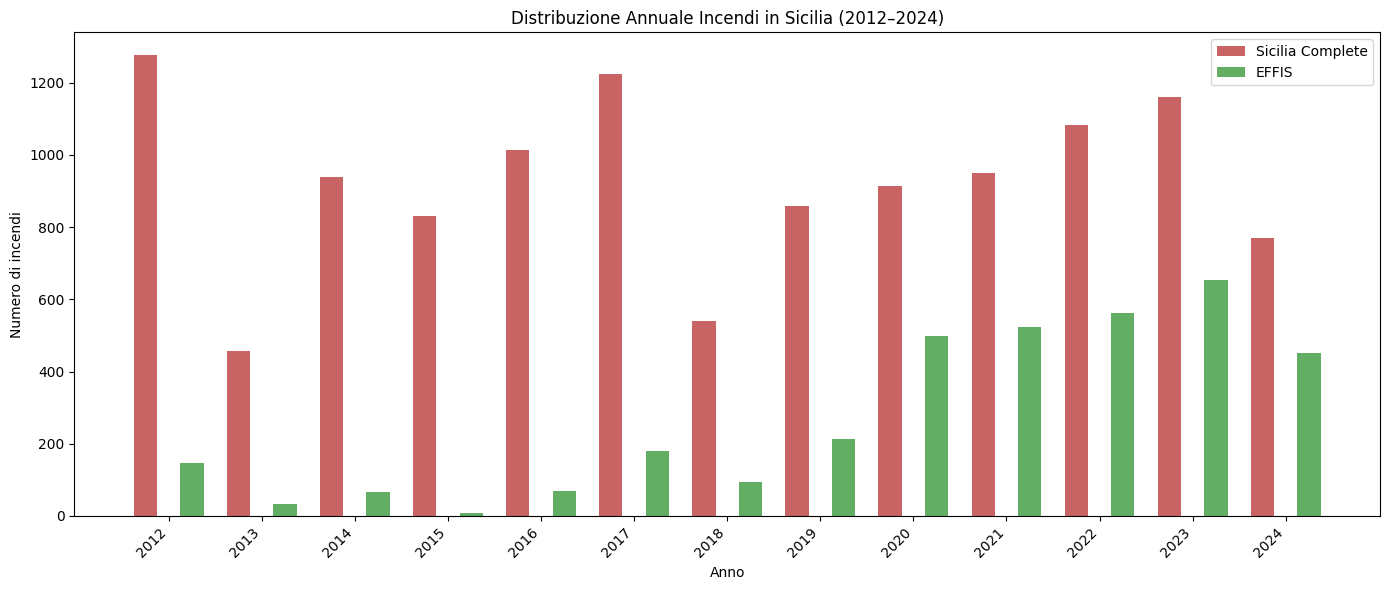


--- Distribuzione stagionale (Sicilia Complete) ---
Winter: 124
Spring: 750
Summer: 8478
Autumn: 2662


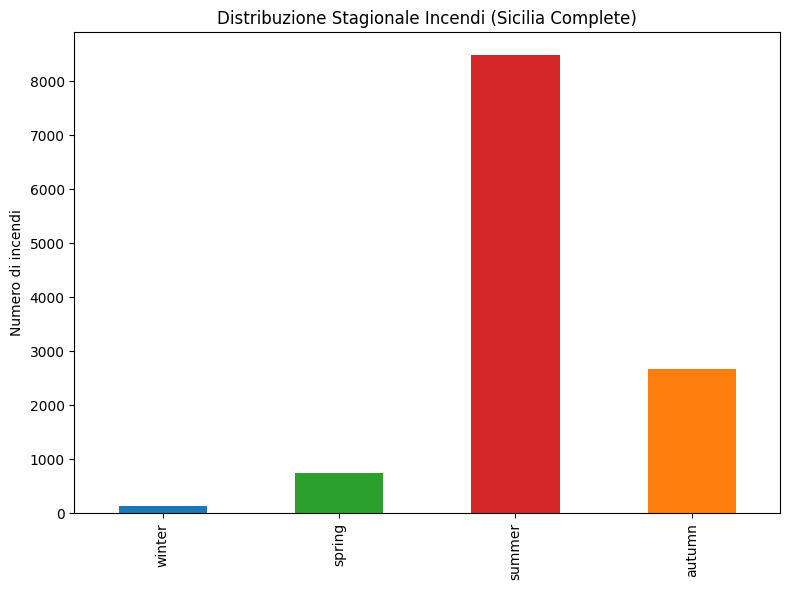

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Caricamento dati
effis_sicilia = gpd.read_file("Sicilia_2012_2024/effis_sicilia.geojson")
sicilia_fires_complete = gpd.read_file("Sicilia_2012_2024/fires_complete_filtered.geojson")

print(f"N. incendi EFFIS: {len(effis_sicilia)}")
print(f"N. incendi Sicilia Complete: {len(sicilia_fires_complete)}")

# Conversione colonne data in datetime
effis_sicilia["initialdate"] = pd.to_datetime(effis_sicilia["initialdate"], errors='coerce')
sicilia_fires_complete["DATI_WEB.DBO.DFCNSIINCD_DENORM.DTAINIZIOFUOCO"] = pd.to_datetime(
    sicilia_fires_complete["DATI_WEB.DBO.DFCNSIINCD_DENORM.DTAINIZIOFUOCO"],
    format='%B %d, %Y',
    errors='coerce'
)

# Rinomina colonne per comodità
sicilia_fires_complete = sicilia_fires_complete.rename(
    columns={"DATI_WEB.DBO.DFCNSIINCD_DENORM.DTAINIZIOFUOCO": "start_date"}
)
effis_sicilia = effis_sicilia.rename(columns={"initialdate": "start_date"})

# Aggiunta colonne anno e mese
sicilia_fires_complete["year"] = sicilia_fires_complete["start_date"].dt.year
sicilia_fires_complete["month"] = sicilia_fires_complete["start_date"].dt.month

effis_sicilia["year"] = effis_sicilia["start_date"].dt.year

# Analisi annuale
years_range = range(2012, 2025)

annual_fa = sicilia_fires_complete["year"].value_counts().reindex(years_range, fill_value=0).sort_index()
annual_effis = effis_sicilia["year"].value_counts().reindex(years_range, fill_value=0).sort_index()

# Plot annuale
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.25
index = np.arange(len(years_range))

ax.bar(index - bar_width, annual_fa, bar_width,
       color="firebrick", alpha=0.7, label="Sicilia Complete")
ax.bar(index + bar_width, annual_effis, bar_width,
       color="forestgreen", alpha=0.7, label="EFFIS")

plt.title("Distribuzione Annuale Incendi in Sicilia (2012–2024)")
plt.xlabel("Anno")
plt.ylabel("Numero di incendi")
plt.xticks(index, labels=years_range)
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analisi stagionale
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

def count_by_season(gdf):
    counts = {}
    for season, months in seasons.items():
        counts[season] = gdf[gdf["month"].isin(months)].shape[0]
    return counts

season_counts_fa = count_by_season(sicilia_fires_complete)

print("\n--- Distribuzione stagionale (Sicilia Complete) ---")
for season in seasons:
    print(f"{season.capitalize()}: {season_counts_fa[season]}")

# Plot stagionale
fig, ax = plt.subplots(figsize=(8, 6))
pd.Series(season_counts_fa).plot(
    kind='bar',
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax,
    title='Distribuzione Stagionale Incendi (Sicilia Complete)'
)
ax.set_ylabel("Numero di incendi")
plt.tight_layout()
plt.show()



Effis Sicilia Statistics:
count    3496.000000
mean      114.406465
std       326.683286
min         0.000000
25%        12.000000
50%        37.000000
75%       104.000000
max      9778.000000
Name: area_ha, dtype: float64
Somma totale superficie EFFIS: 399,965.00 ha

Fires Sicilia Complete Statistics:
count    11982.00000
mean        29.70859
std        141.96230
min          0.00000
25%          1.43235
50%          4.72470
75%         15.98230
max       7241.74210
Name: area_ha, dtype: float64
Somma totale superficie Sicilia Complete: 355,968.33 ha


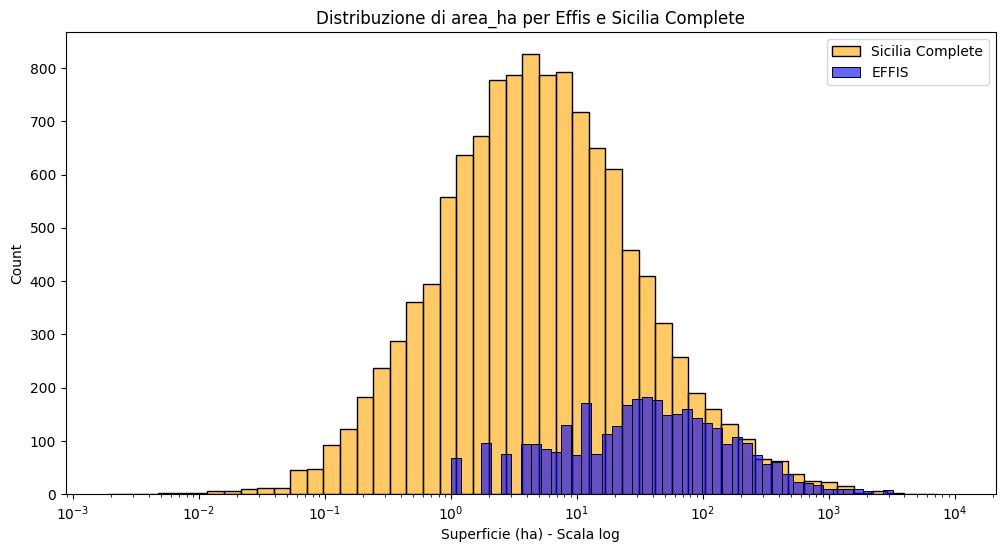

In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Caricare i dati
effis_sicilia = gpd.read_file("Sicilia_2012_2024/effis_sicilia.geojson")
sicilia_fires_complete = gpd.read_file("Sicilia_2012_2024/fires_complete_filtered.geojson")

# Assicurarsi che 'area_ha' sia numerico
effis_sicilia["area_ha"] = pd.to_numeric(effis_sicilia["area_ha"], errors="coerce")
sicilia_fires_complete["area_ha"] = pd.to_numeric(sicilia_fires_complete["DATI_WEB.DBO.DFCNSIINCD_DENORM.TOTSUP"], errors="coerce")

# 1. Statistiche descrittive
print("Effis Sicilia Statistics:")
print(effis_sicilia["area_ha"].describe())
print(f"Somma totale superficie EFFIS: {effis_sicilia['area_ha'].sum():,.2f} ha")
print("\nFires Sicilia Complete Statistics:")
print(sicilia_fires_complete["area_ha"].describe())
print(f"Somma totale superficie Sicilia Complete: {sicilia_fires_complete['area_ha'].sum():,.2f} ha")

# 2. Istogrammi
plt.figure(figsize=(12,6))
sns.histplot(sicilia_fires_complete["area_ha"], bins=50, color="orange", alpha=0.6, label="Sicilia Complete", log_scale=True)
sns.histplot(effis_sicilia["area_ha"], bins=50, color="blue", alpha=0.6, label="EFFIS", log_scale=True)
plt.legend()
plt.title("Distribuzione di area_ha per Effis e Sicilia Complete")
plt.xlabel("Superficie (ha) - Scala log")
plt.show()


EFFIS SOLO GRANDI